In [11]:
%matplotlib inline


In [2]:
import splitfolders
splitfolders.ratio("Dataset", output="Dataset1", seed=1337, ratio=(.65, .25,.1), group_prefix=None)

Copying files: 33920 files [02:39, 212.89 files/s]


In [12]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from PIL import Image
from torchsummary import summary
plt.ion()  

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [19]:
data_transforms = {
    "train": transforms.Compose(
        [
               
            transforms.Resize([224, 224]),
            
            transforms.ToTensor(),
            # Normalize input channels using mean values and standard deviations of ImageNet.
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
    "val": transforms.Compose(
        [
            transforms.Resize([224, 224]),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
    'test': transforms.Compose([
        transforms.Resize(224),
       
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        
    ]),
}

data_dir = 'Dataset1'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val','test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val','test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val','test']}
class_names = image_datasets['train'].classes

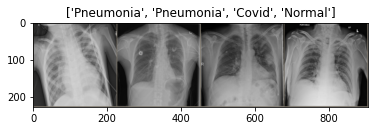

In [20]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])
        

In [21]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [22]:
model_ft = models.alexnet(pretrained=True)
for param in model_ft.parameters():
    param.requires_grad = False
model_ft.classifier[4] = nn.Linear(4096,1024)
model_ft.classifier[6] = nn.Linear(1024,3)
model_ft.classifier.add_module("7", nn.LogSoftmax(dim = 1))
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.0001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [23]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9
----------
train Loss: 0.7426 Acc: 0.6837
val Loss: 0.5442 Acc: 0.7951

Epoch 1/9
----------
train Loss: 0.5984 Acc: 0.7574
val Loss: 0.4779 Acc: 0.8177

Epoch 2/9
----------
train Loss: 0.5544 Acc: 0.7771
val Loss: 0.4455 Acc: 0.8324

Epoch 3/9
----------
train Loss: 0.5326 Acc: 0.7904
val Loss: 0.4328 Acc: 0.8334

Epoch 4/9
----------
train Loss: 0.5184 Acc: 0.7949
val Loss: 0.4287 Acc: 0.8357

Epoch 5/9
----------
train Loss: 0.5069 Acc: 0.8003
val Loss: 0.3930 Acc: 0.8519

Epoch 6/9
----------
train Loss: 0.4922 Acc: 0.8053
val Loss: 0.4000 Acc: 0.8460

Epoch 7/9
----------
train Loss: 0.4876 Acc: 0.8052
val Loss: 0.3906 Acc: 0.8512

Epoch 8/9
----------
train Loss: 0.4822 Acc: 0.8106
val Loss: 0.3930 Acc: 0.8496

Epoch 9/9
----------
train Loss: 0.4846 Acc: 0.8064
val Loss: 0.3871 Acc: 0.8530

Training complete in 11m 16s
Best val Acc: 0.853049


In [24]:
torch.save(model_ft,"modelf.pth")

In [25]:
testloader = torch.utils.data.DataLoader(image_datasets['test'], batch_size=10, shuffle=True, num_workers=4)
correct, total = 0, 0
correct_count, all_count = 0, 0
for images,labels in testloader:
  for i in range(len(labels)):
    if torch.cuda.is_available():
        images = images.cuda()
        labels = labels.cuda()
    img = images[i].view(1,3, 224, 224)
    with torch.no_grad():
        logps = model_ft(img)

    
    ps = torch.exp(logps)
    probab = list(ps.cpu()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.cpu()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

Number Of Images Tested = 3395

Model Accuracy = 0.8615611192930781


In [26]:

def predict(model, test_image_name):
    '''
    Function to predict the class of a single test image
    Parameters
        :param model: Model to test
        :param test_image_name: Test image

    '''
    transform = data_transforms['val']

    test_image = Image.open(test_image_name).convert('RGB')
    test_image_tensor = transform(test_image)
    plt.imshow(test_image)
    
    

    if torch.cuda.is_available():
        test_image_tensor = test_image_tensor.view(1, 3, 224, 224).cuda()
    else:
        test_image_tensor = test_image_tensor.view(1,3, 224, 224)
   
    with torch.no_grad():
        model.eval()
        # Model outputs log probabilities
        out = model(test_image_tensor)
         # Reverse the log function in our output
        output = torch.exp(out)
    
    # Get the top predicted class, and the output percentage for
    # that class
    probs, classes = output.topk(1, dim=1)
    if classes.item()==0 :
        a="Covid"
    elif classes.item()==1 :
        a="Normal"
    else:
        a="Pneumonia"
     
    return probs.item(),a